<a href="https://colab.research.google.com/github/PieroPastor/quantum-chess-bot-player/blob/main/Quantum_Chess_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network learns from MCTS to play Quantum Chess

## Librerías

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from random import random, seed, randint
from math import exp
import time
import copy
import gc
import csv

#TENSORFLOW
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, LayerNormalization, Add
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2

#SKLEARN
from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.metrics import accuracy_score, balanced_accuracy_score   # para manejar metricas de desempeño
from sklearn.metrics import classification_report  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # para manejar matrices de confusion

## Tratamiento de datos

En esta sección se cargará el dataset generado por Monte Carlo. Además se procederá a convertir los outputs en one hot, esto para poder predecir que selección tomo; se utiliza esta metdología, ya que, si únicamente predijera el número, existiría un sesgo por las distancias entre los outputs en el espacio.

In [ ]:
df = pd.read_csv('dataset.csv', header=None, names=["Player"]+[i for i in range(64)]+["Movement", "Beg1", "Beg2", "End1", "End2", "Crown"]) #Carga y pone cabezales
df = df.drop_duplicates() #Borra duplicados
df = df.sample(frac=1).reset_index(drop=True) #Borra entradas duplicadas
df

,Player,0,1,2,3,4,5,6,7,8,...,60,61,62,63,Movement,Beg1,Beg2,End1,End2,Crown
0,1,-82,0,-66,-81,-69,-66,-75,-82,-80,...,69,66,75,82,1,57,-1,40,-1,0
1,1,-82,0,-66,-81,-69,0,-75,-82,0,...,69,66,75,82,2,57,-1,42,40,0
2,1,-82,-75,-66,-66,-69,0,-75,-82,0,...,69,66,75,82,1,57,-1,33,-1,0
3,0,-82,-75,-66,0,-69,-66,-75,81,-80,...,69,66,75,82,2,30,-1,28,27,0
4,1,-82,-75,-66,-81,-69,-66,-75,-82,-82,...,69,66,0,82,2,57,-1,42,40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2801,0,-82,-75,-66,-81,-69,-66,-75,-82,-80,...,69,66,75,82,1,8,-1,24,-1,0
2802,0,-82,-75,-66,0,-69,-66,-75,-82,0,...,0,66,75,82,2,27,-1,51,36,0
2803,1,0,0,-82,0,-69,-66,66,0,0,...,0,69,0,0,2,33,-1,27,16,0
2804,0,-82,-75,-66,-81,-69,0,0,-82,-80,...,0,66,75,82,1,4,-1,12,-1,0


In [ ]:
one_hot1 = []
one_hot2 = []
one_hot3 = []
for mov in df.iloc[:,65]:
  if mov == 1:
    one_hot1.append(1)
    one_hot2.append(0)
    one_hot3.append(0)
  elif mov == 2:
    one_hot1.append(0)
    one_hot2.append(1)
    one_hot3.append(0)
  else:
    one_hot1.append(0)
    one_hot2.append(0)
    one_hot3.append(1)
df['Movement_1'] = one_hot1
df['Movement_2'] = one_hot2
df['Movement_3'] = one_hot3
df.drop(columns=["Movement"], inplace=True)
df.shape

(2806, 73)

In [ ]:
df = pd.get_dummies(df, columns=["Beg1", "Beg2", "End1", "End2", "Crown"], drop_first=True).astype(int)

Para tener un dataset más consistente, se generarán filas de ceros en las cuales no se haya conseguido información. (Esto es improbable y se toma únicamente como prevención).

In [ ]:
def dummies(prefix, category, df):
  for cat in category:
    if f'{prefix}_{cat}' not in df.columns: df[f'{prefix}_{cat}'] = 0
cat_esperadas = [i for i in range(-1,64)] #Va desde no usado hasta el top permitido
cat_crown = [0, 1, 2, 3, 4, 5]
dummies("Beg1", cat_esperadas[1:65], df)
dummies("Beg2", cat_esperadas, df)
dummies("End1", cat_esperadas[1:65], df)
dummies("End2", cat_esperadas, df)
dummies("Crown", cat_crown, df)
df.shape

(2806, 332)

In [ ]:
df.head()

,Player,0,1,2,3,4,5,6,7,8,...,Beg2_62,Beg2_63,End1_0,End2_-1,Crown_0,Crown_1,Crown_2,Crown_3,Crown_4,Crown_5
0,1,-82,0,-66,-81,-69,-66,-75,-82,-80,...,0,0,0,0,0,0,0,0,0,0
1,1,-82,0,-66,-81,-69,0,-75,-82,0,...,0,0,0,0,0,0,0,0,0,0
2,1,-82,-75,-66,-66,-69,0,-75,-82,0,...,0,0,0,0,0,0,0,0,0,0
3,0,-82,-75,-66,0,-69,-66,-75,81,-80,...,0,0,0,0,0,0,0,0,0,0
4,1,-82,-75,-66,-81,-69,-66,-75,-82,-82,...,0,0,0,0,0,0,0,0,0,0


## Algoritmos

### Generador de una red neuronal

Esta función calculará el peso máximo de los bounds para así normalizar el peso de la red y que funcione dentro de la función de probabilidad de cambio en el SBMA.

In [ ]:
def calcular_peso_maximo(bounds, n_inputs):
  # Peso acumulado
  peso_total = 0

  # Inicializar el número de neuronas previas
  n_prev = n_inputs

  # Cálculo de las capas ocultas dinámicas usando el valor máximo de neuronas de bounds
  for i in range(0, len(bounds)):
    n_neurons_max = bounds[i][1]  # Usamos el máximo de las neuronas para cada capa
    if n_neurons_max > 0:  # Solo calcular si hay neuronas en la capa
      peso_capa = (n_prev * n_neurons_max) + n_neurons_max
      peso_total += peso_capa
      n_prev = n_neurons_max  # Actualizar n_prev para la siguiente capa

  # Cálculo de las capas de salida (siempre presentes) usando los tamaños fijos
  salidas = {'o_mov': 3, 'o_beg1': 64, 'o_beg2': 65, 'o_end1': 64, 'o_end2': 65, 'o_pown': 6}
  for salida, n_unidades in salidas.items():
    peso_capa = (n_prev * n_unidades) + n_unidades
    peso_total += peso_capa

  # Convertir a bytes y luego a MB
  peso_bytes = peso_total * 4  # Cada peso ocupa 4 bytes
  peso_mb = peso_bytes / (1024 ** 2)
  return peso_mb

El generador será un vector. Este vector sería de n dimensiones (con topología [cantidad neuronas capa 1, ..., cantidad de neuronas capa n]).

Además se colocarán regulizadores, dropouts y normalizadores para evitar tanto como overfitting, como que se dispare la pérdida.

In [ ]:
def gen_neural_network(config, input_size, optimizer='adam'):
  # Entrada de tamaño 65
  input_layer = Input(shape=(input_size, 1))  # Entrada como 1D con 1 canal
  prev = input_layer

  # Capas densas
  for i in range(0, len(config)):
    n_neurons = config[i]
    if n_neurons > 0:
      prev = Dense(n_neurons, activation='relu',kernel_regularizer=l2(0.01))(prev)
      prev = BatchNormalization()(prev)
      prev = Dropout(rate=0.2)(prev)

  prev = Flatten()(prev)

  # Salidas del modelo
  o_mov = Dense(3, activation='softmax', name='o_mov')(prev)
  o_beg1 = Dense(64, activation='softmax', name='o_beg1')(prev)
  o_beg2 = Dense(65, activation='softmax', name='o_beg2')(prev)
  o_end1 = Dense(64, activation='softmax', name='o_end1')(prev)
  o_end2 = Dense(65, activation='softmax', name='o_end2')(prev)
  o_pown = Dense(6, activation='softmax', name='o_pown')(prev)

  model = Model(inputs=input_layer, outputs=[o_mov, o_beg1, o_beg2, o_end1, o_end2, o_pown])

  if optimizer == 'adam': optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
  else: optimizer = SGD(learning_rate=0.001, clipvalue=1.0)

  model.compile(optimizer=optimizer,
                loss={'o_mov': 'categorical_crossentropy',
                      'o_beg1': 'categorical_crossentropy',
                      'o_beg2': 'categorical_crossentropy',
                      'o_end1': 'categorical_crossentropy',
                      'o_end2': 'categorical_crossentropy',
                      'o_pown': 'categorical_crossentropy'},
                metrics={'o_mov': 'mae', 'o_beg1': 'mae', 'o_beg2': 'mae',
                          'o_end1': 'mae', 'o_end2': 'mae', 'o_pown': 'mae'})

  return model

Esta función separará un único y en varios para que así se le proporcione uno a cada cabezal de la red.

In [ ]:
def spliter(y):
  divisiones = [3, 64, 65, 64, 65, 6]
  # Calcular los índices para dividir
  indices = np.cumsum(divisiones) #Me manda los indices que consigue sumando esas cantidades

  o_mov = y[:, :indices[0]]  # Primer segmento (3 columnas)
  o_beg1 = y[:, indices[0]:indices[1]]  # Segundo segmento (64 columnas)
  o_beg2 = y[:, indices[1]:indices[2]]  # Tercer segmento (65 columnas)
  o_end1 = y[:, indices[2]:indices[3]]  # Cuarto segmento (64 columnas)
  o_end2 = y[:, indices[3]:indices[4]]  # Quinto segmento (65 columnas)
  o_pown = y[:, indices[4]:indices[5]]  # Último segmento (6 columnas)
  return [o_mov, o_beg1, o_beg2, o_end1, o_end2, o_pown]

### Evaluador de Cross Validation

In [ ]:
def evalua_modeloCV(model_builder, input_size, X, y, n_folds=5, epochs=10, batch_size=32, seed_random_state=7, patience=None, model=None, verbose=False):
  accuracies, histories = list(), list()
  # prepara folds
  kfold = KFold(n_splits=n_folds, random_state=seed_random_state, shuffle=True)
  if model == None: modelo = gen_neural_network(model_builder, input_size) # define modelo MLP
  else: modelo = model
  # realiza la cross-validacion
  for train_ix, test_ix in kfold.split(X):   # por cada fold de test
    trainX, trainY, testX, testY = X[train_ix], y[train_ix], X[test_ix], y[test_ix] # selecciona los sets de training y de test
    trainY = spliter(trainY)
    testY = spliter(testY)
    if patience is not None:
      early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
      history = modelo.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=(testX, testY), callbacks=[early_stopping], verbose=0)
    else: history = modelo.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=(testX, testY), verbose=0) # entrena el modelo
    # obtiene metricas de evaluacion en el fold de test del modelo entrenado
    acc = modelo.evaluate(testX, testY, verbose=0)
    acc = np.mean(acc[7:13])
    if verbose: print('> %.3f' % (acc * 100.0))
    accuracies.append((1-acc) if not np.isnan(acc) else 0)   # guarda la acuracia obtenida en el fold  de test
    histories.append(history)  # guarda hitórico de evolucion de scores entrenamiento  (loss y acuracias)
    #promedio = sum(accuracies) / len(accuracies)
  if model is None:
    total_params = modelo.count_params()  # Total de parámetros (pesos + biases)
    bytes_per_param = 4  # Tamaño típico para float32 (4 bytes por parámetro)
    size_in_bytes = total_params * bytes_per_param
    size_in_mb = size_in_bytes / (1024 ** 2)  # Conversión a MB
    del modelo
    #K.clear_session()
    gc.collect()
    return accuracies, histories, size_in_mb
  return accuracies, histories

### Evaluador Train-Test

In [ ]:
def evalua_modeloTT(model_builder, input_size, X, y, test_size=0.2, epochs=10, batch_size=32, seed_random_state=42, patience=None, model=None, verbose=False):
  if model == None: modelo = gen_neural_network(model_builder, input_size) # define modelo MLP
  else: modelo = model
  trainX, testX, trainY, testY = train_test_split(X, y, test_size=test_size, random_state=seed_random_state)
  trainY = spliter(trainY)
  testY = spliter(testY)
  if patience is not None:
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = modelo.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=(testX, testY), callbacks=[early_stopping], verbose=0)
  else: history = modelo.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=(testX, testY), verbose=0) # entrena el modelo
  acc = modelo.evaluate(testX, testY, verbose=0)
  acc = np.mean(acc[7:13])
  if verbose: print('> %.3f' % (acc * 100.0))
  if model is None:
    total_params = modelo.count_params()  # Total de parámetros (pesos + biases)
    bytes_per_param = 4  # Tamaño típico para float32 (4 bytes por parámetro)
    size_in_bytes = total_params * bytes_per_param
    size_in_mb = size_in_bytes / (1024 ** 2)  # Conversión a MB
    del modelo
    #K.clear_session()
    gc.collect()
    return [(1-acc) if not np.isnan(acc) else 0], history, size_in_mb
  return [(1-acc)], history

### Bat Algorithm

Metaheurístico que priorizará la explotación en la mejora de soluciones, no obstante de igual manera es explorativo.

In [ ]:
def bat_algorithm(n_bats, n_generations, dimension, bounds, X_train, y_train, input_size, patience=5, n_folds=5, epochs=10, batch_size=32, seed_random_state=7, test_size=0.2, alpha=0.9, gamma=0.9, fitness_func='cross_validation', initial_bats=None, initial_fitness=None, verbose=False, unique=True):
  def get_fitness(bat):
    if fitness_func == 'cross_validation': acc, his, tam = evalua_modeloCV(bat, input_size, X_train, y_train, n_folds, epochs, batch_size, seed_random_state, patience, verbose=verbose)
    elif fitness_func == 'train_test': acc, his, tam = evalua_modeloTT(bat, input_size, X_train, y_train, test_size, epochs, batch_size, seed_random_state, patience, verbose=verbose)
    else: raise ModuleNotFoundError
    max = calcular_peso_maximo(bounds, input_size)
    tam  = tam/max
    return (np.mean(acc)/(1+0.05*tam))

  if initial_bats is None:
    bats = np.random.randint(low=bounds[:, 0], high=bounds[:, 1]+1, size=(n_bats, dimension)) #Generación de murciélagos, 2*dimension porque se duplica
    fitness = np.array([get_fitness(bat) for bat in bats])
  else:
    bats = initial_bats
    fitness = initial_fitness

  velocities = np.zeros_like(bats, dtype=float) #Inicializa en 0 las velocidades de los murcielagos

  #Ahora que se incializó se analizará al mejor murciélago
  best_bat = bats[np.argmax(fitness)] #Elige el mayor valor de fitness (porque se busca maximizar el accuracy)
  best_fitness = np.max(fitness)
  if verbose: print("Best Bat: ", best_bat, " - Fitness: ", best_fitness)

  # Inicialización ecolocalización
  A = np.random.uniform(0.5, 1.0, size=n_bats)  # Loudness (Si el murciélago está realizando una búsqueda más activa e intensa)
  r = np.random.uniform(0.0, 1.0, size=n_bats)  # Probabilidad de emisión (Probabilidad de que el murciélago realice una búsqueda global, o sea en todo el espacio, ya fuera de su camino)
  alpha, gamma = alpha, gamma #Alpha: factor de actualización de la loudness para reducirlo, Gamma: factor de actualización de la probabilidad de emisión para aumentarla (factor de enfriamiento)
  iteration_changed = 0 #Controlador para no llevar demasiadas generaciones sin mejora

  #Ajustes de los murciélagos
  for gen in range(n_generations): #Avanza en las generaciones
    for i in range(n_bats): #Recorre los murciélagos
      # Frecuencia aleatoria
      freq = np.random.uniform(0, 1) #Se utiliza en la actualización de la velocidad del murciélago, está para que no se pase con velocidad.
      velocities[i] += (bats[i] - best_bat) * freq #Actualiza la velocidad del murcielago, en función a la distancia entre el murciélago actual y el mejor, para dirigirse ahí
      candidate_bat = bats[i] + velocities[i].astype(int) #Actualiza la información generando un murciélago auxiliar, simulando el viaje desde el murciélago actual hasta el mejor con la velocidad hallada
      # Limitar dentro del rango permitido
      candidate_bat = np.clip(candidate_bat, bounds[:, 0], bounds[:, 1]+1) #Se asegura que el nuevo murciélago sea uno con valores admitidos, si no está en los límites los ajusta
      # Decisión ecolocalización, cuantas más generaciones halla, este valor r[i] tenderá más a cero probando con más murciélagos
      if np.random.rand() > r[i]: #Si se da un valor mayor que la probabilidad de emisión, entonces no se evalúa, si se da uno menor entonces realiza una búsqueda local
        candidate_fitness = get_fitness(candidate_bat) #Saca el fitness
        if candidate_fitness > fitness[i] or np.random.rand() < A[i]: #Si se tiene mejor fitness, o si se tiene un número aleatorio menor que el loudness. Esto segundo porque si se realiza una búsqueda muy activa también es bueno
          bats[i] = candidate_bat
          fitness[i] = candidate_fitness #Actualiza valores para el mismo murciélago si mejoró globalmente o está buscando localmente
          A[i] *= alpha #Reduce el loudness para que no se actualice todo el tiempo este murciélago
          r[i] = r[i] * (1 - np.exp(-gamma * gen)) #Aumenta la probabilidad de emisión porque está teniendo mejores resultados o porque se actualizará menos veces
          if candidate_fitness > best_fitness: #En caso sea porque mejoró el fitness global, entonces actualiza a mejor murciélago
            best_bat = candidate_bat
            best_fitness = candidate_fitness
            if verbose: print("Best Bat: ", best_bat, " - Fitness: ", best_fitness)
    if not unique and fitness[np.argmax(fitness)] <= best_fitness : #Si el mejor fitness generado es peor o igual que el mejor actual
      if iteration_changed == patience: break #No ha habido mejora por 5 generaciones entonces se termina
      iteration_changed += 1
    else:
      best_fitness = fitness[np.argmax(fitness)] #Actualiza el mejor fitness
      iteration_changed = 0
  if unique: return best_bat, best_fitness #Retorna el mejor murciélago (mejor combinación), con su fitness
  else: return best_bat, best_fitness, bats, fitness

### Memetic Algorithm

Metaheurístico que prioriza la exploración generando nuevos individuos, pero de igual manera es explotativo.

In [ ]:
def memetic_algorithm(n_chromosomes, n_generations, dimension, bounds, X_train, y_train, input_size, patience=5, n_folds=5, epochs=10, batch_size=32, seed_random_state=7, test_size=0.2, t_casamiento=0.4, t_mutacion=0.3, p_casamiento=0.8, fitness_func='cross_validation', initial_chromosomes=None, initial_fitness=None, verbose=False, unique=True):
  def get_fitness(chromo):
    if fitness_func == 'cross_validation': acc, his, tam = evalua_modeloCV(chromo, input_size, X_train, y_train, n_folds, epochs, batch_size, seed_random_state, patience, verbose=verbose)
    elif fitness_func == 'train_test': acc, his, tam = evalua_modeloTT(chromo, input_size, X_train, y_train, test_size, epochs, batch_size, seed_random_state, patience, verbose=verbose)
    else: raise ModuleNotFoundError
    max = calcular_peso_maximo(bounds, input_size)
    tam  = tam/max
    return (np.mean(acc)/(1+0.05*tam))

  def genera_poblacion():
    chromos = np.random.randint(low=bounds[:, 0], high=bounds[:, 1]+1, size=(n_chromosomes, dimension)) #Generación de cromosomas, 2*dimension porque se duplica
    return chromos

  def calcular_supervivencia(poblacion, fitness):
    sumafo = 0
    supervivencia = []
    for f in fitness: #Suma los fitness
      sumafo += f

    for f in fitness:
      fit = round(100*f/sumafo)
      supervivencia.append(fit)

    return supervivencia

  def carga_ruletas(supervivencia):
    cont = 0
    ruleta = []
    for i in range(len(supervivencia)):
      #Repite tantas veces como el fit sea para que el random de un índice y
      #con ese se seleccione del arreglo ej:
      #rand=5 -> [0, 0, 0, 0, 0,, 4, ,4, 4, 4, 4] -> selecciona el 0
      for _ in range(supervivencia[i]):
        ruleta.append(i)
        cont += 1
    return ruleta

  def seleccion(poblacion, fitness):
    padres = []
    supervivencia = calcular_supervivencia(poblacion, fitness)
    ruleta = carga_ruletas(supervivencia)
    n_padres = round(len(poblacion)*t_casamiento)
    cont = 0
    while True:
      ind = randint(0, int(2**31-1))%len(ruleta)
      padres.append(poblacion[ruleta[ind]])
      cont += 1
      if cont >= n_padres: return np.array(padres)

  def mutacion(poblacion, padres, fitness):
    cont = 0
    nmuta = round(len(padres[0]) *t_mutacion) #Mutará la mitad del cromosoma
    for p in padres:
      pad = copy.deepcopy(p) #Genera una copia para guardarla
      for _ in range(nmuta):
        ind = randint(0, int(2**31-1))%len(padres[0])
        pad[ind] = randint(0, int(2**31-1))%(bounds[ind][1]+1)
        pad = np.clip(pad, bounds[:, 0], bounds[:, 1]+1) #Hace clip para asegurarse que no haya desborde
      if not np.any(np.all(poblacion == pad, axis=1)):
        poblacion.append(pad) #Para evitar repetidos
        fitness.append(get_fitness(pad)) #Agrega su fitness

  def generar_hijo(padre, madre):
    pos=round(len(padre)*p_casamiento) #Porcentaje de cuantos genes tendrá de cada padre
    hijo = []
    for i in range(pos): hijo.append(padre[i]) #Tendrá p_casamiento% del padre
    for i in range(pos, len(padre)): hijo.append(madre[i]) #Tendrá el resto
    return hijo

  def casamiento(poblacion, padres, fitness):
    for i in range(len(padres)):
      for j in range(len(padres)):
        if i != j:
          hijo = np.array(generar_hijo(padres[i], padres[j]))
          if not np.any(np.all(poblacion == hijo, axis=1)):
            poblacion.append(hijo) #Para evitar repetidos
            fitness.append(get_fitness(hijo)) #Agrega su fitness

  def eliminar_chromosomas(poblacion, fitness, n_chromosomes):
    best = []
    best_f = []

    for i in range(n_chromosomes):
      aux = np.argmax(fitness) #El mejor fitness hasta ahora
      best.append(copy.deepcopy(poblacion[aux]))
      best_f.append(fitness[aux])
      del fitness[aux]
      del poblacion[aux]
    return best, best_f #Retorna todo lo mejor

  if initial_chromosomes is None:
    poblacion = genera_poblacion()
    fitness = [get_fitness(chromo) for chromo in poblacion]
  else:
    poblacion = initial_chromosomes
    fitness = list(initial_fitness)

  best_chromosome = poblacion[np.argmax(fitness)]
  best_fitness = fitness[np.argmax(fitness)]
  poblacion = list(poblacion)
  iteration_changed = 0

  for i in range(n_generations):
    seed(time.time())
    padres = seleccion(poblacion, fitness)
    casamiento(poblacion, padres, fitness)
    mutacion(poblacion, padres, fitness)
    poblacion, fitness = eliminar_chromosomas(poblacion, fitness, n_chromosomes) #Para disminuir la población
    if not unique and fitness[np.argmax(fitness)] <= best_fitness : #Si el mejor fitness generado es peor o igual que el mejor actual
      if iteration_changed == patience: break #No ha habido mejora por 5 generaciones entonces se termina
      iteration_changed += 1
    else:
      best_fitness = fitness[np.argmax(fitness)] #Actualiza el mejor fitness
      iteration_changed = 0

  if unique: return best_chromosome, best_fitness #Retorna el mejor murciélago (mejor combinación), con su fitness
  else: return best_chromosome, best_fitness, poblacion, np.array(fitness)

### Simulated Bat Memetic Annealing

Se usará simulated annealing como base para adaptar y así poder ir cambiando de metaheurística para la optimización de hiperparámetros, de esta manera se irá ajustando para conseguir la mejor configuración de red neuronal.

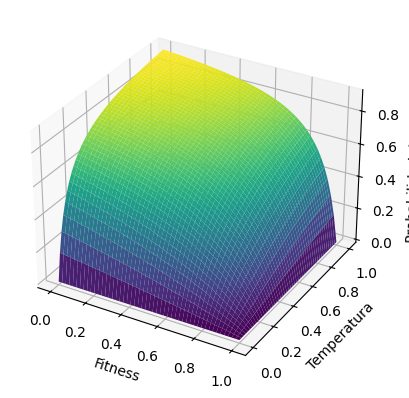

In [ ]:
# Crear un rango de valores para x e y
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)  # Crear una malla 2D de valores x e y

#Función
alpha = 10
z = 1 - (1 / (1 + alpha * y * (1 - x))) #Fitness actual : x, Temperatura : y, Alpha es un regulador para darle un valor mínimo justo en (1,1), (1,0), (0,0)

z = np.clip(z, 0, 2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Graficar la superficie
ax.plot_surface(x, y, z, cmap='viridis')

# Añadir etiquetas a los ejes
ax.set_xlabel('Fitness')
ax.set_ylabel('Temperatura')
ax.set_zlabel('Probabilidad de cambio')

# Mostrar el gráfico
plt.show()

El fitness que se utilizará en cada metaheurístico tendrá la capacidad de maximizar el accuracy, como minimizar el tamaño en MB de la red neuronal.

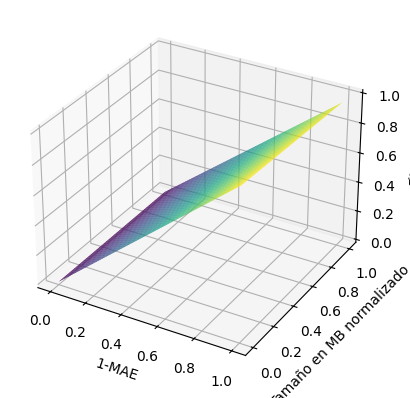

In [ ]:
# Crear un rango de valores para x e y
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)  # Crear una malla 2D de valores x e y

#Función
alpha = 0.05
z = x/(1+alpha*y)#1-MAE : x, Tamaño normalizado : y, Alpha es un regulador para darle proporción al peso

z = np.clip(z, 0, 2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Graficar la superficie
ax.plot_surface(x, y, z, cmap='viridis')

# Añadir etiquetas a los ejes
ax.set_xlabel('1-MAE')
ax.set_ylabel('Tamaño en MB normalizado')
ax.set_zlabel('Fitness')

# Mostrar el gráfico
plt.show()

In [ ]:
def simulated_bat_memetic_annealing(n_configs, dimension, bounds, X_train, y_train, input_size, T0=0.5, DR=0.99, maxIter=50, n_generations=15, f_escala=10, threshold=1, patience=5, n_folds=5, epochs=10, batch_size=32, seed_random_state=7, test_size=0.2, alpha=0.9, gamma=0.9, t_casamiento=0.4, t_mutacion=0.3, p_casamiento=0.8, fitness_func='cross_validation', verbose=False, log=False):
  algorithm = 0
  alg_best_fitness = algorithm
  best_fitness = 0
  best_config = None
  current_fitness = 0
  fitness = None
  configs = None
  T = T0 #Valor inicial de temperatura
  t = 0

  while t < maxIter:
    print("Iteration {}, \tTemperature = {}, \tBest score = {}, \tCurrent score = {}, \tCurrent Algorithm = {}, \tCurrent Best = {}".format(t, T, best_fitness, current_fitness, 'Memetic' if algorithm else 'Bat', best_config))
    if algorithm == 0: current_config, current_fitness, configs, fitness = bat_algorithm(n_configs, n_generations, dimension, bounds, X_train, y_train, input_size, patience, n_folds, epochs, batch_size, seed_random_state, test_size, alpha, gamma, fitness_func, initial_bats=configs, initial_fitness=fitness, verbose=False, unique=False)
    if algorithm == 1: current_config, current_fitness, configs, fitness = memetic_algorithm(n_configs, n_generations, dimension, bounds, X_train, y_train, input_size, patience, n_folds, epochs, batch_size, seed_random_state, test_size, t_casamiento, t_mutacion, p_casamiento, fitness_func, initial_chromosomes=configs, initial_fitness=fitness, verbose=False, unique=False)
    delta = float(current_fitness-best_fitness)
    if delta > 0: #Si el fitness actual es mejor que el mejor parcial se acepta, y se continúa con el mismo algoritmo
      best_fitness = current_fitness
      best_config = current_config
      alg_best_fitness = algorithm
    if log:
      with open('SBMA.csv', mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([best_fitness])
        file.close()
    probabilidad = 1 - (1 / (1 + f_escala * T * (1 - current_fitness)))
    if random() < probabilidad: algorithm = 0 if algorithm else 1
    if best_fitness >= threshold: break #Si el accuracy ya tiene el threshold deseado
    T = DR*T #La nueva temperatura decae con factor de decaimiento, es una forma eficiente del schedule Ti = T0*(DR^i)
    t += 1 #Avanza la iteración
  return best_config, best_fitness

### Greedy Search

Algoritmo estándar en la optimización de hiperparámetros para comparar con el metaheurístico. Se hizo la variación de data aleatoria para que así tenga al menos más explotación.

In [ ]:
def greedy_search(dimension, bounds, X_train, y_train, input_size, n_options=4, patience=5, n_folds=5, epochs=10, batch_size=32, seed_random_state=7, test_size=0.2, fitness_func='cross_validation', verbose=False, log=False):
  def get_fitness(config, input, x_train, y_train):
    if fitness_func == 'cross_validation': acc, his, tam = evalua_modeloCV(config, input_size, x_train, y_train, n_folds, epochs, batch_size, seed_random_state, patience, verbose=verbose)
    elif fitness_func == 'train_test': acc, his, tam = evalua_modeloTT(config, input_size, x_train, y_train, test_size, epochs, batch_size, seed_random_state, patience, verbose=verbose)
    else: raise ModuleNotFoundError
    max = calcular_peso_maximo(bounds, input_size)
    tam  = tam/max
    return (np.mean(acc)/(1+0.05*tam))

  param_grid = []
  iterators = np.zeros(n_options, dtype=int) #El máximo será n_options que es la cantidad de fors
  total = n_options ** dimension

  for i in range(dimension):
    neurons = []
    for _ in range(n_options):
      neurons.append(randint(1, int(2**31-1))%(bounds[0][1]+1)) #Selecciona un número aleatorio de neuronas
    param_grid.append(neurons) #Añade las opciones para la capa n

  # Inicializar mejores parámetros y puntuación
  best_config = []
  best_score = -np.inf

  #Generalización de n fors, es decir la cantidad de for que se manden lo soportará
  for i in range(total): #Recorre todas las combinaciones de neuronas
    config = []
    for j in range(n_options):
      config.append(neurons[iterators[j]])
    fit = get_fitness(config, input_size, X_train, y_train)
    if fit > best_score:
      best_config = config
      best_score = fit
      print("Best Config = {}, \tBest Score = {}".format(best_config, best_score))
    iterators[0] += 1 #Actualiza el contador mas bajo
    for k in range(n_options): #Recorre todos los iteradores para actualizarlos
      if iterators[k] == n_options: #Si el k actual es n_options entonces lo setea 0 y le agrega uno al siguiente
        iterators[k] = 0 #Lo setea en 0
        if k < n_options-1: iterators[k+1] += 1 #Actualiza en uno el iterador de arriba, como itera en el arreglo se van pasando entre los siguientes
      else: break #Como aún no termina alguna iteración solo actualiza el primero y sale
    if log:
      with open('GREEDY.csv', mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([best_fitness])
        file.close()
  return best_config, best_score


## Training

In [ ]:
#Separación de data
arr = df.values
X, y = arr[:,0:65], arr[:,65:332]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [ ]:
#Bounds debe mandarse este objeto
dimension = max_layers = 6
bounds = np.tile([[0, 1024]], (max_layers, 1)) #Indica que hay mínimo de 8 neuronas, y max 127, y que las funciones de activación de 1 a 4, se repite cuantas capas querramos

In [ ]:
config, best_fitness = simulated_bat_memetic_annealing(7, dimension, bounds, X_train, y_train, 65, n_generations=5, fitness_func='train_test')

In [ ]:
config_2, best_fitness_2 = greedy_search(5, bounds, X_train, y_train, 65, fitness_func='train_test')

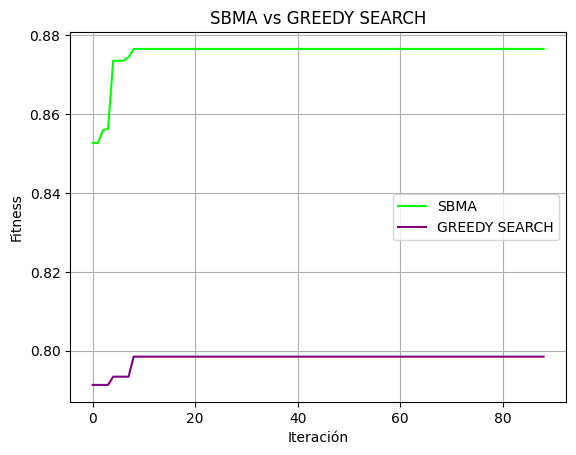

In [ ]:
df1 = pd.read_csv('SBMA.csv', header=None)
df2 = pd.read_csv('GREEDY.csv', header=None)

# Crear una columna de tiempo para cada uno (puede ser el índice de las iteraciones)
df1['Iteracion'] = df1.index
df2['Iteracion'] = df2.index

# Graficar ambos datos en el mismo gráfico
plt.plot(df1['Iteracion'], df1[0], label='SBMA', color='lime')  # Primer archivo en azul
plt.plot(df2['Iteracion'], df2[0], label='GREEDY SEARCH', color='purple')  # Segundo archivo en rojo

# Añadir detalles a la gráfica
plt.xlabel('Iteración')
plt.ylabel('Fitness')
plt.title('SBMA vs GREEDY SEARCH')
plt.legend()  # Añadir leyenda para distinguir las dos series
plt.grid(True)  # Añadir una cuadrícula

# Mostrar la gráfica
plt.show()

GREEDY: Best Config = [385, 415, 385, 385], 	Best Score = 0.7984790622400103

SBMA: Best score = 0.8765378294944639,    Current Best = [ 561    9  176  293 1008   95]

In [ ]:
#Genera los dos modelos e imprime el summary de cada uno
config = [561, 9, 176, 293, 1008, 95]
model_adam = gen_neural_network(config, 65)
model_sgd = gen_neural_network(config, 65, optimizer='sgd')
model_adam.summary()
model_sgd.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 65, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 65, 561)        │          1,122 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 65, 561)        │          2,244 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 65, 561)        │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 65, 9)          │          5,058 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 65, 9)          │             36 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 65, 9)          │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 65, 176)        │          1,760 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 65, 176)        │            704 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 65, 176)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 65, 293)        │         51,861 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 65, 293)        │          1,172 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 65, 293)        │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 65, 1008)       │        296,352 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 65, 1008)       │          4,032 │ dense_4[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 65, 1008)       │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 65, 95)         │         95,855 │ dropout_4[0][0]        │
├──────────────────────

 Total params: 2,109,568 (8.05 MB)

 Trainable params: 2,105,284 (8.03 MB)

 Non-trainable params: 4,284 (16.73 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 65, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 65, 561)        │          1,122 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 65, 561)        │          2,244 │ dense_6[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 65, 561)        │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 65, 9)          │          5,058 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 65, 9)          │             36 │ dense_7[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 65, 9)          │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 65, 176)        │          1,760 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 65, 176)        │            704 │ dense_8[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 65, 176)        │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 65, 293)        │         51,861 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 65, 293)        │          1,172 │ dense_9[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 65, 293)        │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 65, 1008)       │        296,352 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 65, 1008)       │          4,032 │ dense_10[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 65, 1008)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)     

 Total params: 2,109,568 (8.05 MB)

 Trainable params: 2,105,284 (8.03 MB)

 Non-trainable params: 4,284 (16.73 KB)

In [ ]:
#Compara los dos optimizadores, el de Adam y SGD
acc_adam, hist_adam = evalua_modeloCV(config, 65, X_train, y_train, model=model_adam, verbose=True)
acc_sgd, hist_sgd = evalua_modeloCV(config, 65, X_train, y_train, model=model_sgd, verbose=True)
print("Adam: ", acc_adam)
print("SGD: ", acc_sgd)

> 9.171
> 9.393
> 9.399
> 9.194
> 9.570
> 9.027
> 8.639
> 10.549
> 8.802
> 8.713
Adam:  [0.908291170373559, 0.9060669538254539, 0.9060076968744397, 0.9080550456419587, 0.9042971921153367]
SGD:  [0.9097282895818353, 0.9136069286614656, 0.8945059472074112, 0.9119837485874692, 0.9128709138991932]


### Plotting

In [ ]:
# Muestra un boxplot de las acuracias obtenidas en crosvalidacion
def show_boxplot_accuracy(accuracies):
  # muetra un resumen de las acuracies
  print('1-MAE: mean=%.3f std=%.3f, n=%d' % (np.mean(accuracies)*100, np.std(accuracies)*100, len(accuracies)))
  # boxplot de las accuracias
  plt.boxplot(accuracies)
  plt.show()

# Plotea curvas de diagnostico de aprendizaje
def plot_learning_curves(histories):
  for i in range(len(histories)):
    # plotea la curva de loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
  plt.show()

1-MAE: mean=90.654 std=0.148, n=5


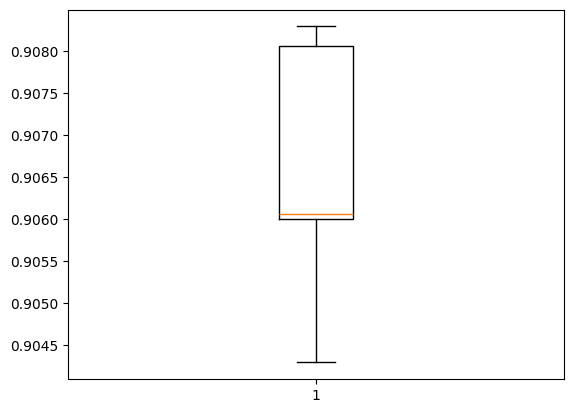

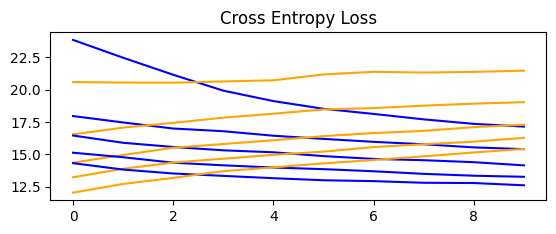

In [ ]:
show_boxplot_accuracy(acc_adam)   # muestra boxplot de resultados de acuracias de crossvalidacion
plot_learning_curves(hist_adam)     # muestra curvas de aprendizaje de cada modelo entrenado en crossvalidacion

1-MAE: mean=90.854 std=0.714, n=5


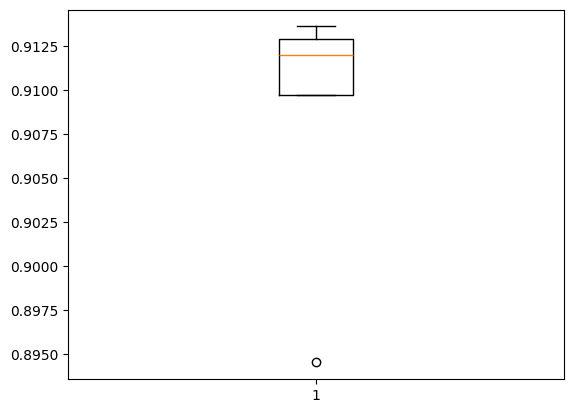

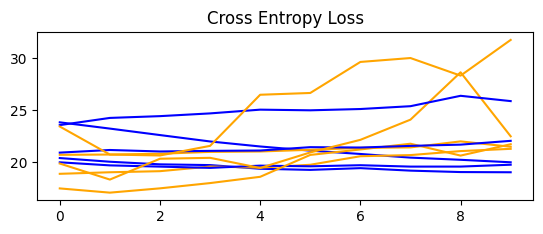

In [ ]:
show_boxplot_accuracy(acc_sgd)   # muestra boxplot de resultados de acuracias de crossvalidacion
plot_learning_curves(hist_sgd)     # muestra curvas de aprendizaje de cada modelo entrenado en crossvalidacion

### Final Train

In [ ]:
#Splitea los y porque son varios outputs
y_train = spliter(y_train)
y_test = spliter(y_test)

In [ ]:
# Define modelo final
modelo_finalMLP = gen_neural_network(config, 65, optimizer='sgd') #Aún no se ejecuta nada, pero se asume de momento que será Adam

# Entrena  modelo final
modelo_finalMLP.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Evalua modelo final en  dataset de validacion
acc = modelo_finalMLP.evaluate(X_test, y_test, verbose=0)
print('MAE > %.3f' % (np.mean(acc[7:13])*100))

output_valid = modelo_finalMLP.predict(X_test)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 361ms/step - loss: 24.0310 - o_beg1_loss: 5.2345 - o_beg1_mae: 0.0306 - o_beg2_loss: 5.3453 - o_beg2_mae: 0.0303 - o_end1_loss: 3.1426 - o_end1_mae: 0.0246 - o_end2_loss: 0.0000e+00 - o_end2_mae: 0.0154 - o_mov_loss: 1.4637 - o_mov_mae: 0.3970 - o_pown_loss: 0.0000e+00 - o_pown_mae: 0.1667
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 348ms/step - loss: 23.1463 - o_beg1_loss: 5.0632 - o_beg1_mae: 0.0305 - o_beg2_loss: 5.0817 - o_beg2_mae: 0.0302 - o_end1_loss: 3.1769 - o_end1_mae: 0.0250 - o_end2_loss: 0.0000e+00 - o_end2_mae: 0.0154 - o_mov_loss: 1.0021 - o_mov_mae: 0.3060 - o_pown_loss: 0.0000e+00 - o_pown_mae: 0.1667
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 372ms/step - loss: 22.2985 - o_beg1_loss: 4.8457 - o_beg1_mae: 0.0304 - o_beg2_loss: 4.7854 - o_beg2_mae: 0.0301 - o_end1_loss: 2.9554 - o_end1_mae: 0.0248 - o_end2_loss: 0.0000e+00 - o_end2_mae: 0.0154 - o_mov_loss: 0.9127 - o_mov_mae: 0.3046 - o_pown_loss: 0.0000e+00 - o_pown_mae: 0.1667
E

In [ ]:
# Guarda los pesos de la red
modelo_finalMLP.save("weights.h5")

## Análisis de errores

Se necesita este análisis para saber si está prediciendo movidas que realizaría el algoritmo de Monte Carlo

In [ ]:
def gen_confusion_matrix(output, test, i):
  # obtiene las categorias de las muestras de validacion (lo contrario de one hot)
  digitos_reales = np.argmax(test[i], axis=1) #Como se quiere analizar por parámetro, se revisará por trozos el vector
  digitos_predichos = np.argmax(output[i], axis=1)
  # obtiene matriz de confusion
  conf_mx = confusion_matrix(digitos_reales, digitos_predichos)
  # normaliza las filas de la matriz de confusion
  row_sums = conf_mx.sum(axis=1, keepdims=True)
  norm_conf_mx = conf_mx / row_sums
  # coloca 0 en la diagonal para enfocarnos en los errores
  np.fill_diagonal(norm_conf_mx, 0)
  # plotea
  plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
  plt.show()

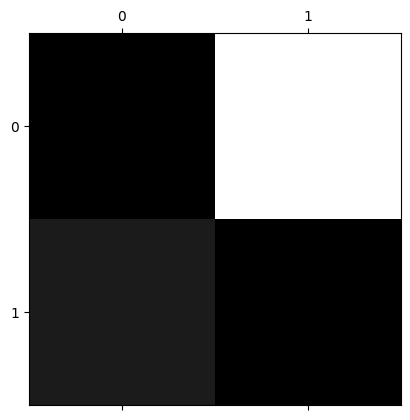

In [ ]:
#Matriz de confusión para el movimiento seleccionado
gen_confusion_matrix(output_valid, y_test, 0)

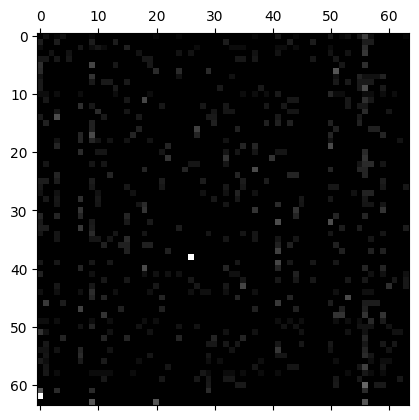

In [ ]:
#Matriz de confusión para el comienzo 1
gen_confusion_matrix(output_valid, y_test, 1)

<ipython-input-34-69c8b8d1f333>:9: RuntimeWarning: invalid value encountered in divide
  norm_conf_mx = conf_mx / row_sums


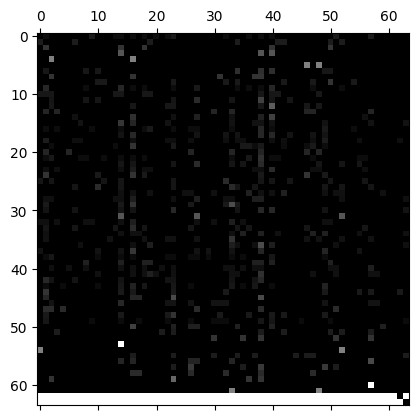

In [ ]:
#Matriz de confusión para el comienzo 2
gen_confusion_matrix(output_valid, y_test, 2)

<ipython-input-34-69c8b8d1f333>:9: RuntimeWarning: invalid value encountered in divide
  norm_conf_mx = conf_mx / row_sums


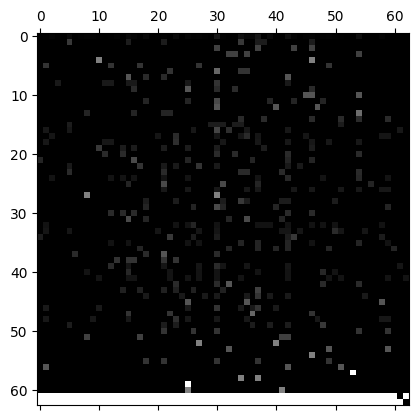

In [ ]:
#Matriz de confusión para el destino 1
gen_confusion_matrix(output_valid, y_test, 3)

<ipython-input-34-69c8b8d1f333>:9: RuntimeWarning: invalid value encountered in divide
  norm_conf_mx = conf_mx / row_sums


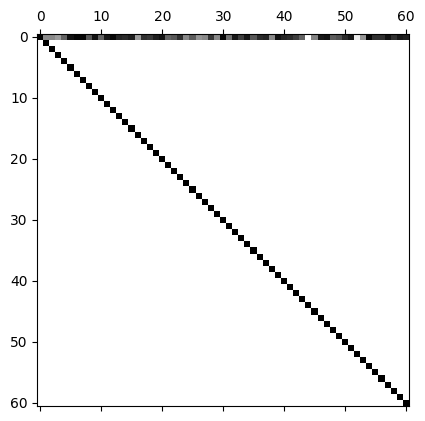

In [ ]:
#Matriz de confusión para el destino 2
gen_confusion_matrix(output_valid, y_test, 4)

<ipython-input-34-69c8b8d1f333>:9: RuntimeWarning: invalid value encountered in divide
  norm_conf_mx = conf_mx / row_sums


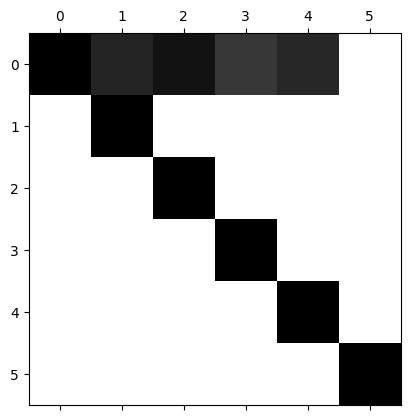

In [ ]:
#Matriz de confusión para la coronación
gen_confusion_matrix(output_valid, y_test, 5)